In [17]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
matplotlib.rc('font', **{'size': 15})

#Create instance of ElasticSearch using the Atlas host server
es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)
 

In [148]:
query = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [153]:
import ast
import time
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHour = 60*60*1000
milliHalfHour = 30*60*1000

#Get files from hour interval
start = currentMilliTime - milliHour
end = currentMilliTime


response = es1.search(index="rucio-events*", body=ast.literal_eval(query%(start,end)), request_timeout=600)

In [154]:
#Get important variables from response

fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []
fileTimestamp = []
for r in response['hits']['hits']:
    fileTimestamp.append(r['fields']['@timestamp'])
    fileSize.append(r['_source']['payload']['file-size'])
    activity.append(r['_source']['payload']['activity'])
    startedAt.append(r['_source']['payload']['started_at'])
    submittedAt.append(r['_source']['payload']['submitted_at'])
    transferredAt.append(r['_source']['payload']['transferred_at'])


In [155]:
fileSize = np.array(fileSize)
activity = np.array(activity)

uniqueActivity = np.unique(activity)
print(np.shape(fileSize))

(6160,)


In [167]:
import datetime
from datetime import datetime
import time

#Some useful functions for date conversion

def convertDateToEpoch(dates):
    
    epochDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        epochDates.append(epoch)
    return epochDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

In [190]:
#Convert string timestamps to usable quantities

timeInQueue = getSecondsDifference(convertDateToEpoch(submittedAt),
                                   convertDateToEpoch(startedAt))
timeTotal = getSecondsDifference(convertDateToEpoch(submittedAt),
                                 convertDateToEpoch(transferredAt))
timeInTransfer = getSecondsDifference(convertDateToEpoch(startedAt),
                                      convertDateToEpoch(transferredAt))

dateTime = convertDateToEpoch(transferredAt)

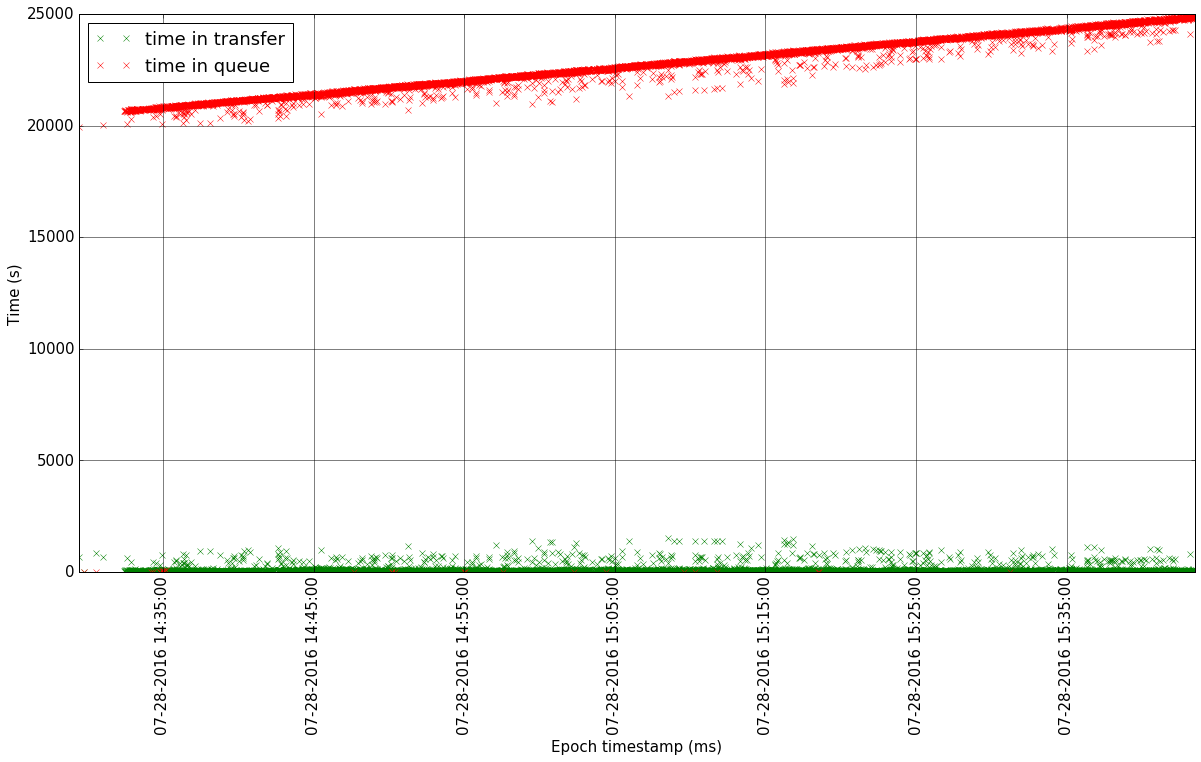

In [191]:
import matplotlib.dates as dt
#fileTimestamp = np.array(fileTimestamp)
#dateTime = dt.epoch2num(fileTimestamp/1000.)

plt.figure(figsize=(20,10))
plt.plot(dateTime,timeInTransfer,'gx',label='time in transfer')
plt.plot(dateTime,timeInQueue,'rx',label='time in queue')
plt.grid(which='minor')
plt.grid(which='major',linestyle='-')
plt.xlabel('Epoch timestamp (ms)')
plt.ylabel('Time (s)')
plt.xticks(rotation= 90 )
plt.legend(loc='upper left')
ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%m-%d-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

In [192]:
#Get fields from another host

es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

query = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "10m",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "%s"
          }
        }
      }
    }
  }
}'''

In [193]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'

tic = time.time()

queuedQuery = ast.literal_eval(query%(src,dst,start,end,start,end,'queued-total'))    
packetLossQuery = ast.literal_eval(query%(src,dst,start,end,start,end,'packetloss'))  
dashThroughputQuery = ast.literal_eval(query%(src,dst,start,end,start,end,'mbps-dashb-1h')) 
ftsThroughputQuery = ast.literal_eval(query%(src,dst,start,end,start,end,'mbps-fts-1h')) 
faxThroughputQuery = ast.literal_eval(query%(src,dst,start,end,start,end,'mbps-fax-1h')) 

queuedResponse = es2.search(index="atlas_ddm-metrics*", body=queuedQuery, request_timeout=600) 
packetLossResponse = es2.search(index="atlas_ddm-metrics*", body=packetLossQuery, request_timeout=600)
dashThroughputResponse = es2.search(index="atlas_ddm-metrics*", body=dashThroughputQuery, request_timeout=600)
ftsThroughputResponse = es2.search(index="atlas_ddm-metrics*", body=ftsThroughputQuery, request_timeout=600)
faxThroughputResponse = es2.search(index="atlas_ddm-metrics*", body=faxThroughputQuery, request_timeout=600)

queuedData = []
packetLoss = []
dashThroughput = []
faxThroughput = []
ftsThroughput = []
timestamp = []

for r in queuedResponse['aggregations']['2']['buckets']:
    queuedData.append(r['1']['value'])
    timestamp.append(r['key'])    
for r in packetLossResponse['aggregations']['2']['buckets']:
    packetLoss.append(r['1']['value'])
for r in dashThroughputResponse['aggregations']['2']['buckets']:
    dashThroughput.append(r['1']['value'])
for r in ftsThroughputResponse['aggregations']['2']['buckets']:
    ftsThroughput.append(r['1']['value'])
for r in faxThroughputResponse['aggregations']['2']['buckets']:
    faxThroughput.append(r['1']['value'])

#Replace None values with NaNs
queuedData = np.array(queuedData,dtype=np.float)
packetLoss = np.array(packetLoss,dtype=np.float)
timestamp = np.array(timestamp,dtype=np.float)
faxThroughput = np.array(faxThroughput,dtype=np.float)
ftsThroughput = np.array(ftsThroughput,dtype=np.float)
dashThroughput = np.array(dashThroughput,dtype=np.float)


toc = time.time()

print('This aggregation and fetching took %f seconds'%(toc-tic))

This aggregation and fetching took 1.280873 seconds


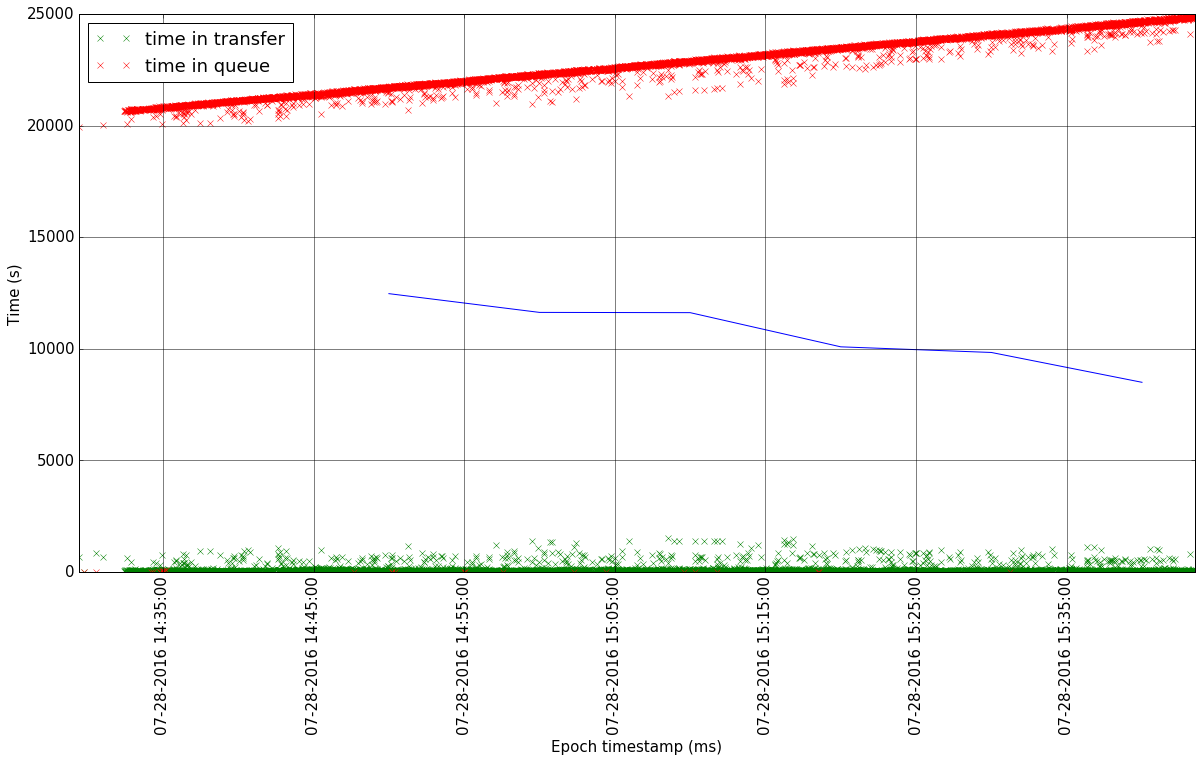

In [197]:
import matplotlib.dates as dt


timestamp = np.array(timestamp)
dateTime2 = dt.epoch2num(timestamp/1000.)
plt.figure(figsize=(20,10))

plt.plot(dateTime2,queuedData)
plt.plot(dateTime,timeInTransfer,'gx',label='time in transfer')
plt.plot(dateTime,timeInQueue,'rx',label='time in queue')
plt.grid(which='minor')
plt.grid(which='major',linestyle='-')
plt.xlabel('Epoch timestamp (ms)')
plt.ylabel('Time (s)')
plt.xticks(rotation= 90 )
plt.legend(loc='upper left')
ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%m-%d-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

array([ nan,  nan,  nan,  nan,  nan,  nan])

In [ ]:
from sklearn import tree, cross_validation,preprocessing
import pandas as pd

#Build dictionary
data = {'activity':activity,'filesize':fileSize}

#Convert to panda dataframe, convert categorical, and convert back
df = pd.DataFrame(data)
dummyActivity = np.array(pd.get_dummies(df['activity']))
treeData = np.hstack((dummyActivity,fileSize[:,None]))


#Create decision tree regressor and fit to data, holding some data
#back for validation

clf = tree.DecisionTreeRegressor(min_samples_split=20,random_state = 90)
clf = clf.fit(treeData,np.array(timeInQueue,dtype=np.int64))


In [ ]:
1469544153914